In [10]:
# Third-party Library Imports
import pandas as pd

import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from unidecode import unidecode
from bias_correction import BiasCorrection
from sklearn.metrics import (
    r2_score,
    mean_squared_error as mse,
)

### 1. Read SCM & ERA data

In [11]:
# Contains selected ERA-features, as identified in 3_yield_model_with_era.ipynb
era_final = pd.read_csv("files/ERA/features/era_features_filtered_case11.csv")
era_raw = pd.read_csv("files/ERA/raw/era_basic_preprocessed_filtered_feature_structure_1993_2016.csv")
era_raw = era_raw.assign(model="ERA", init_month=12)

# Contains hindcasts as csv with basic preprocessing
c3s = pd.read_csv("c3s/data/c3s_hindcasts.csv")
nmme = pd.read_csv("nmme/data/nmme_hindcasts.csv")
apcc = pd.read_csv("clik-apcc/data/apcc_hindcasts.csv")

# Concatenate SCM and filter by year
scm = pd.concat([nmme, c3s, apcc], ignore_index=True).drop_duplicates()
scm = scm.loc[(scm["year"].between(1993, 2016)) & (scm["init_month"].between(9, 11))].reset_index(drop=True)

# Store variables that are used through this notebook
init_months = scm["init_month"].unique().tolist()
scm_models = [c for c in scm.model.unique().tolist() if c != "ERA"]
weather_columns_final = [c for c in era_final.columns if ("rain" in c) or ("tmean" in c)]
crop_seasons = scm["year"].unique().tolist()
relevant_municipalities = list(set([c.split("_")[1] for c in era_final.columns if ("rain" in c) or ("tmean" in c)]))

new_dict = dict.fromkeys(["tmean", "rain"])
new_dict["tmean"] = dict.fromkeys([c.split("_")[1] for c in weather_columns_final if ("tmean" in c)])
new_dict["rain"] = dict.fromkeys([c.split("_")[1] for c in weather_columns_final if ("rain" in c)])
for var in new_dict:
    for loc in new_dict[var]:
        new_dict[var][loc] = list(set([int(c.split("_")[-1]) for c in weather_columns_final if (var in c) and (loc in c)]))
weather_columns_raw = []
for var in new_dict:
    for loc in new_dict[var]:
        for month in new_dict[var][loc]:
            weather_columns_raw.append("{}_{}_{}".format(var, loc, month))

era_raw = era_raw.loc[:, ["year", "model", "init_month"] + weather_columns_raw]

# Preview
scm.sample(5)

,model,year,init_month,forecasted_month,rain,tmean,lat,lon
166767,DWD,2001,10,10,0.004247,19.571558,-29.00,-61.00
236659,JMA,2010,9,11,0.001598,20.098474,-35.75,-67.75
317840,ECCC,1998,11,11,0.002117,14.866052,-39.00,-58.00
256128,METFR,2002,11,11,0.004425,20.470087,-34.00,-59.00
349088,PNU,2014,9,11,0.003665,20.238611,-30.00,-62.50


### 2. Filter SCM locations

**2.1 Obtain polygon shapes of relevant municipalities**

To forecast wheat yield in Argentina, we use weather data from two locations - Buenos Aires Coronel Dorrego and Buenos Aires Hipolito Yrigoyen. SCM data is often provided in e.g. 1° x 1° grid cells. For each location, we need to find the grid cells that are closest. 

In [12]:
# Read all polygon shapes of Argentinian municipalities
gdf_adm2 = gpd.read_file("files/shapefiles/arg_admbnda_adm2_unhcr2017.shp")[["ADM1_ES", "ADM2_ES", "geometry"]]
# Concatenate name of state and municipality
gdf_adm2["name"] = gdf_adm2[["ADM1_ES", "ADM2_ES"]].apply(lambda x: unidecode(x[0].lower()) + " " + unidecode(x[1].lower()), axis=1)
# Filter polygon shapes by the relevant municipalities
gdf_adm2 = gdf_adm2.loc[gdf_adm2["name"].isin(relevant_municipalities), ["name", "geometry"]].reset_index(drop=True)
# Convert to dictionary for easier access
name_to_shape = gdf_adm2.set_index("name")["geometry"].to_dict()
# Preview
name_to_shape

/var/folders/wz/1l02swfn32g2q18shkm7rzsr0000gn/T/ipykernel_30826/3210894579.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gdf_adm2["name"] = gdf_adm2[["ADM1_ES", "ADM2_ES"]].apply(lambda x: unidecode(x[0].lower()) + " " + unidecode(x[1].lower()), axis=1)


{'buenos aires coronel suarez': <POLYGON Z ((-61.603 -36.993 0, -61.735 -37.093 0, -61.735 -37.095 0, -61.73...>,
 'buenos aires hipolito yrigoyen': <POLYGON Z ((-61.45 -36.052 0, -61.435 -36.039 0, -61.393 -36.072 0, -61.333...>}

**2.2 Preview SCM locations and relevant municipality locations**

<Axes: >

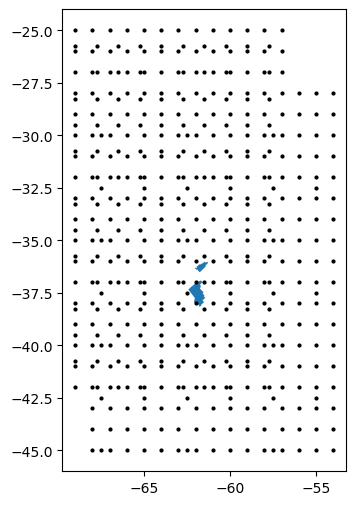

In [13]:
appc_models = ["BOM", "CWB", "HMC", "KMA", "PNU"]
c3s_models = ["CMCC", "DWD", "ECCC", "ECMWF", "JMA", "METFR", "UKMO"]
# Convert SCM dataframe to geodataframe to facilitate spatial filtering in the next section
scm = gpd.GeoDataFrame(scm, geometry=gpd.points_from_xy(scm["lon"], scm["lat"]), crs="EPSG:4326")

# Preview SCM locations and municipality polygons
base = gdf_adm2.plot(figsize=(6,6), linewidth=.2)
gpd.GeoDataFrame(scm.loc[:, ["geometry", "lat", "lon"]].drop_duplicates(), geometry="geometry", crs="EPSG:4326").plot(ax=base,  color="black", markersize=4)

**2.3 Filter SCM hindcasts**

For each relevant municipality, we select a grid cell location from each SCM that is closest to that municipality. If a SCM has a sparse resolution, it may be that the same grid cell is used for both locations.

In [14]:
filtered_scm = []
for model in scm_models:
    # Get current model and the lat-lon coordinates of its forecasts
    current_model = scm.loc[scm["model"] == model, ["model", "lat", "lon", "geometry"]].drop_duplicates()
    selected_grid_cells = []
    for count, municipality in enumerate(relevant_municipalities):
        # Get the nearest lat-lon pair to all locations (municipalities)
        grid_cell_for_current_municipality = pd.DataFrame(current_model.iloc[current_model.sindex.nearest(name_to_shape[municipality])[1][0]]).transpose().assign(location=municipality).reset_index(drop=True)
        selected_grid_cells.append(grid_cell_for_current_municipality)
    # Save in dataframe
    selected_grid_cells = pd.concat(selected_grid_cells, ignore_index=True)
    # The lat-lon pairs that are selected are merged with the name of their location; all other lat-lon pairs are dropped
    current_model = current_model.merge(selected_grid_cells, on=["model", "lat", "lon", "geometry"], how="left").dropna()
    # Append the locations for this model
    filtered_scm.append(current_model)        
filtered_scm = pd.concat(filtered_scm, ignore_index=True, axis=0)
scm = scm.merge(filtered_scm, on=["model", "lat", "lon", "geometry"]).dropna()
#scm["location"] = scm["location"].str.replace("buenos aires ", "")

<Axes: >

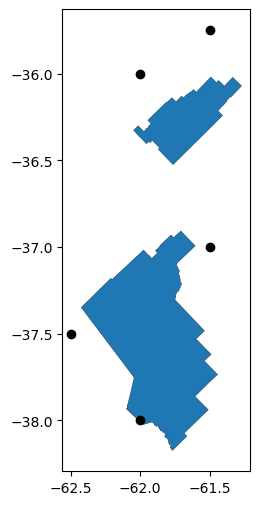

In [15]:
base = gdf_adm2.plot(figsize=(6,6), edgecolor="black", linewidth=.2)
gpd.GeoDataFrame(scm[["geometry", "lat", "lon"]].drop_duplicates(), geometry="geometry", crs="EPSG:4326").plot(ax=base,  color="black")

### 3. Bring SCM hindcasts into feature structure

In [16]:
# Bring NMME hindcasts into right structure where features are columns and rows are model-year-init_month
scm_pivot = scm.pivot(index=["model", "year", "init_month"], columns=["location", "forecasted_month"], values=["tmean", "rain"]).reset_index()
scm_pivot.columns = ["{}_{}_{}".format(c[0], c[1], c[2]) for c in scm_pivot.columns]
scm_pivot.columns = [c.strip("_") for c in scm_pivot.columns]
era_raw.columns = ["year", "model", "init_month"] + weather_columns_raw
weather_columns_raw = [c for c in era_raw.columns if ("rain" in c) or ("tmean" in c)]
scm_pivot = scm_pivot.loc[: , [c for c in scm_pivot.columns if c in era_raw.columns]]
scm_pivot.sample(3)

,model,year,init_month,tmean_buenos aires coronel suarez_9,tmean_buenos aires coronel suarez_11,rain_buenos aires coronel suarez_9,rain_buenos aires coronel suarez_11,rain_buenos aires hipolito yrigoyen_9
568,GFDL,2014,10,NaN,17.997202,NaN,0.002814,NaN
941,NCEP,1994,11,NaN,19.150568,NaN,0.003846,NaN
119,CCSM4,2008,11,NaN,21.354044,NaN,0.003005,NaN


### 4. Adjust Bias

In [17]:
def adjust_bias(observed, predicted, correction_method="basic_quantile"):
    """Apply bias-adjustment to monthly values of hindcasts.
    
    parameters:
     - observed: observed climate data
     - predicted: hindcast data
     - correction_method: bias-correction method to be applied. Can be 'normal_mapping', 'basic_quantile', 'gamma_mapping', 'modified_quantile'
    
    returns: 
     - results: bias-adjusted hindcasts as dataframe  
    """
    adjusted_models = []
    for model in scm_models:
        adjusted_init_months = []
        for month in [9, 10, 11]:
            adjusted_cols = []
            for col in weather_columns_raw:
                adjusted_years = []
                for year in crop_seasons:
                    observations_used_as_reference = observed.loc[(observed["model"] == "ERA") & (observed["year"] != year), col]
                    hindcast_used_as_reference = predicted.loc[(predicted["model"] == model) & (predicted["init_month"] == month), col]
                    hindcast_to_be_adjusted = predicted.loc[(predicted["model"] == model) & (predicted["init_month"] == month) & (predicted["year"] == year), col].copy()
                    y = predicted.loc[(predicted["model"] == model) & (predicted["init_month"] == month) & (predicted["year"] == year), ["model", "year", "init_month"]].copy()
                    # Perform bias-adjustment 
                    if int(col.split("_")[-1]) >= month:
                        bc_col = BiasCorrection(observations_used_as_reference, hindcast_used_as_reference, hindcast_to_be_adjusted)
                        hindcast_to_be_adjusted = bc_col.correct(method=correction_method)
                    hindcast_to_be_adjusted = pd.concat([y, hindcast_to_be_adjusted], axis=1)
                    adjusted_years.append(hindcast_to_be_adjusted)
                adjusted_years = pd.concat(adjusted_years)
                adjusted_cols.append(adjusted_years)
            adjusted_cols = pd.concat(adjusted_cols, axis=1)
            adjusted_cols = adjusted_cols.loc[:,~adjusted_cols.columns.duplicated()]
            adjusted_init_months.append(adjusted_cols)
        adjusted_init_months = pd.concat(adjusted_init_months)
        adjusted_models.append(adjusted_init_months)
    adjusted_models = pd.concat(adjusted_models).sort_values(by=["model", "year", "init_month"])
    return adjusted_models

In [18]:
scm_bias_adjusted = adjust_bias(era_raw, scm_pivot, "basic_quantile")
scm_bias_adjusted.sample(3)

,model,year,init_month,tmean_buenos aires coronel suarez_9,tmean_buenos aires coronel suarez_11,rain_buenos aires coronel suarez_9,rain_buenos aires coronel suarez_11,rain_buenos aires hipolito yrigoyen_9
814,METFR,2000,10,NaN,17.456397,NaN,0.002315,NaN
634,HMC,2012,10,NaN,18.348317,NaN,0.003156,NaN
676,JMA,2002,10,NaN,17.746013,NaN,0.002340,NaN


### Fill with climatology

In [19]:
def r2_by_feature_init_month_and_scm(init_month, climate_models, era_df, scm_df, features):
    model_to_col_to_r2 = dict.fromkeys(climate_models)
    for model in climate_models:
        # Get forecasted features for model and init month, with year as index and all weather columns
        forecasted_scm = scm_df.xs(init_month, level=2, drop_level=True).xs(model, level=0, drop_level=True)[features]
        # Calculate LOYO mean of ERA
        loyo_mean = (era_df[features].sum() - era_df[features]) / (era_df.shape[0] - 1)
        
        ss_total = mse(era_df[features], loyo_mean, multioutput="raw_values")
        ss_model = mse(era_df[features], forecasted_scm, multioutput="raw_values")
        
        current_r2 = 1 - ( ss_model / ss_total )
        
        model_to_col_to_r2[model] = dict(zip(features, current_r2))
    model_to_col_to_r2 = pd.DataFrame(model_to_col_to_r2)
    model_to_col_to_r2[model_to_col_to_r2 < 0] = np.nan
    return model_to_col_to_r2

In [20]:
r2_9 = r2_by_feature_init_month_and_scm(9, scm_models, era_raw, scm_bias_adjusted.set_index(["model", "year", "init_month"]), weather_columns_raw)
r2_9.stack().reset_index().groupby("level_0")["level_1"].apply(list)

level_0
tmean_buenos aires coronel suarez_11    [NASA]
Name: level_1, dtype: object

In [21]:
r2_10 = r2_by_feature_init_month_and_scm(10, scm_models, era_raw, scm_bias_adjusted.set_index(["model", "year", "init_month"]), [c for c in weather_columns_raw if ("_9" not in c)])
r2_10.stack().reset_index().groupby("level_0")["level_1"].apply(list)

level_0
tmean_buenos aires coronel suarez_11    [GFDL, NASA, CMCC, ECMWF, JMA, ECCC]
Name: level_1, dtype: object

In [22]:
r2_11 = r2_by_feature_init_month_and_scm(11, scm_models, era_raw, scm_bias_adjusted.set_index(["model", "year", "init_month"]), [c for c in weather_columns_raw if ("_11" in c)])
r2_11.stack().reset_index().groupby("level_0")["level_1"].apply(list)

level_0
rain_buenos aires coronel suarez_11                      [GFDL, ECMWF, UKMO, ECCC]
tmean_buenos aires coronel suarez_11    [NASA, NCEP, ECMWF, METFR, ECCC, KMA, BOM]
Name: level_1, dtype: object

In [23]:
init_month_to_skill = dict.fromkeys([9, 10, 11])
init_month_to_skill[9] = r2_9.stack().reset_index().groupby("level_0")["level_1"].apply(list).to_dict()
init_month_to_skill[10] = r2_10.stack().reset_index().groupby("level_0")["level_1"].apply(list).to_dict()
init_month_to_skill[11] = r2_11.stack().reset_index().groupby("level_0")["level_1"].apply(list).to_dict()

In [24]:
era_climatology = era_raw.loc[:, ["year"] + weather_columns_raw].set_index("year")
era_climatology = (era_climatology.sum() - era_climatology) / (era_climatology.shape[0] - 1)
era_climatology = era_climatology.reset_index()

# LOYO Climatology
era_columns_no_skill_sep = [c for c in weather_columns_raw if c not in list(init_month_to_skill[9].keys())]
era_columns_no_skill_oct = [c for c in weather_columns_raw if c not in list(init_month_to_skill[10].keys())]
era_columns_no_skill_nov = [c for c in weather_columns_raw if c not in list(init_month_to_skill[11].keys())]

In [25]:
scm_filled_climatology = scm_bias_adjusted.copy()
#scm_basis_expansion_climatology.xs(9, axis=0, level=1, drop_level=True).reset_index().set_index("year")[era_columns_no_skill_sep] = era_climatology[era_columns_no_skill_sep]
sep = scm_filled_climatology.loc[scm_filled_climatology["init_month"] == 9, [c for c in scm_filled_climatology.columns if c not in era_columns_no_skill_sep]].merge(era_climatology[["year"] + era_columns_no_skill_sep], on="year")
oct = scm_filled_climatology.loc[scm_filled_climatology["init_month"] == 10, [c for c in scm_filled_climatology.columns if c not in era_columns_no_skill_oct]].merge(era_climatology[["year"] + era_columns_no_skill_oct], on="year")
nov = scm_filled_climatology.loc[scm_filled_climatology["init_month"] == 11, [c for c in scm_filled_climatology.columns if c not in era_columns_no_skill_nov]].merge(era_climatology[["year"] + era_columns_no_skill_nov], on="year")

scm_filled_climatology = pd.concat([sep, oct, nov], ignore_index=True, axis=0)

In [26]:
for im in [9, 10, 11]:
    for col in list(init_month_to_skill[im].keys()):
        scm_with_no_skill = [c for c in scm_models if c not in init_month_to_skill[im][col]]
        for model in scm_with_no_skill:
            #print("{}, {}, {}".format(im, col, model))
            filter_model = scm_filled_climatology["model"] == model
            filter_init_month = scm_filled_climatology["init_month"] == im
            new_values = (era_raw[col].sum() - era_raw[col]) / (era_raw[col].shape[0] - 1)
            new_values = new_values.values
            #print(new_values)
            scm_filled_climatology.loc[(filter_model) & (filter_init_month), col] = new_values

In [27]:
scm_filled_climatology.loc[scm_filled_climatology["init_month"] == 9, [c for c in weather_columns_raw if int(c.split("_")[-1]) < 9]] = np.nan
scm_filled_climatology.loc[scm_filled_climatology["init_month"] == 10, [c for c in weather_columns_raw if int(c.split("_")[-1]) < 10]] = np.nan
scm_filled_climatology.loc[scm_filled_climatology["init_month"] == 11, [c for c in weather_columns_raw if int(c.split("_")[-1]) < 11]] = np.nan

### 5. Standardize and Basis Expansion

Standardization is done through the LOYO-CV scheme, separately for each model.

In [28]:
def standardize_loyo(data):
    data = data.copy()
    standardized_data = []
    for model in data["model"].unique():
        standardized_data_init_month = []
        for month in data["init_month"].unique():
            standardized_data_current_scm = []
            for year in list(range(1993, 2017)):
                # split
                features_used_for_standardization = data.loc[(data["year"] != year) & (data["model"] == model) & (data["init_month"] == month), [c for c in data.columns if ("tmean" in c) or ("rain" in c)]].reset_index(drop=True).copy()
                features_to_standardize = data.loc[(data["year"] == year) & (data["model"] == model) & (data["init_month"] == month), [c for c in data.columns if ("tmean" in c) or ("rain" in c)]].reset_index(drop=True).copy()
                #print(features_used_for_standardization)
                # standardize
                features_standardized = (features_to_standardize - features_used_for_standardization.mean()) / features_used_for_standardization.std()
                # bring it together
                year_model_init_month = data.loc[(data["year"] == year) & (data["model"] == model) & (data["init_month"] == month), ["year", "model", "init_month"]].reset_index(drop=True)
                standardized_df = pd.concat([year_model_init_month, features_standardized], axis=1)
                standardized_data_current_scm.append(standardized_df)
            current_scm_standardized = pd.concat(standardized_data_current_scm, ignore_index=True)
            standardized_data_init_month.append(current_scm_standardized)
        standardized_data_init_month = pd.concat(standardized_data_init_month)
        standardized_data.append(standardized_data_init_month)
    df_standardized = pd.concat(standardized_data)
    return df_standardized

def apply_basis_expansion(data):
    """
    apply basis expansion to feature-dataframe and return as new dataframe, where original features are replaced with new ones.
    params:
        data: dataframe, with the original features; monthly tmean and monthly rainfall
    returns:
        data_expanded: dataframe, with original features and tmean_squared, rain_squared, and tmean_times_rain features
    """
    df_standardized = standardize_loyo(data)
    df_standardized = df_standardized.sort_values(by=["model", "year", "init_month"]).set_index(["model", "year", "init_month"])
    # Store features and target in variables for better readability
    X_temp = df_standardized.loc[:, [c for c in df_standardized.columns if ("tmean" in c)]]
    X_rain = df_standardized.loc[:, [c for c in df_standardized.columns if ("rain" in c)]]
    
    tmean_loc_m = []
    for k in new_dict["tmean"].keys():
        for m in new_dict["tmean"][k]:
            tmean_loc_m.append("{}_{}".format(k,m))
    rain_loc_m = []
    for k in new_dict["rain"].keys():
        for m in new_dict["rain"][k]:
            rain_loc_m.append("{}_{}".format(k,m))
   
    tmean_rain_intersect = list(np.intersect1d(tmean_loc_m, rain_loc_m))
    
    X_rain_for_tmean = df_standardized.loc[:, ["rain_{}".format(c) for c in tmean_rain_intersect]]
    X_tmean_for_rain = df_standardized.loc[:, ["tmean_{}".format(c) for c in tmean_rain_intersect]]
    
    # basis expansion to linear model
    X_tmean_squared = X_temp.mul(X_temp)
    X_rain_squared = X_rain.mul(X_rain)
    X_rain_tmean = X_rain_for_tmean * X_tmean_for_rain.values
    X_tmean_squared.columns = ["tmeansquared_{}".format("_".join(c.split("_")[1:])) for c in X_tmean_squared.columns]
    X_rain_squared.columns = ["rainsquared_{}".format("_".join(c.split("_")[1:])) for c in X_rain_squared.columns]
    X_rain_tmean.columns = ["tmeanrain_{}".format("_".join(c.split("_")[1:])) for c in X_rain_tmean.columns]
    
    # merge to feature dataframe
    X = (X_tmean_squared.merge(X_rain_squared.merge(X_rain_tmean, left_index=True, right_index=True), left_index=True, right_index=True)).reset_index()

    # standardize expanded features again
    df_standardized = standardize_loyo(X)
    
    return df_standardized

In [29]:
scm_basis_expansion = apply_basis_expansion(scm_filled_climatology)
basis_expansion_weather_columns = [c for c in scm_basis_expansion.columns if ("tmean" in c) or ("rain" in c)]
scm_basis_expansion.sample(3)

,year,model,init_month,tmeansquared_buenos aires coronel suarez_11,tmeansquared_buenos aires coronel suarez_9,rainsquared_buenos aires coronel suarez_9,rainsquared_buenos aires coronel suarez_11,rainsquared_buenos aires hipolito yrigoyen_9,tmeanrain_buenos aires coronel suarez_11,tmeanrain_buenos aires coronel suarez_9
16,2009,NASA,10,-0.274717,NaN,NaN,-0.693338,NaN,0.344661,NaN
7,2000,NCEP,11,1.055899,NaN,NaN,-0.600206,NaN,-0.692458,NaN
18,2011,GFDL,11,0.380902,NaN,NaN,0.779015,NaN,-1.662042,NaN


### 5. Fill past months with ERA data

In [30]:
scm_yield = scm_basis_expansion.merge(era_final[["year", "yield [kg/ha]", "yield anomaly [%]"]], on="year", how="left")
scm_yield = scm_yield[era_final.columns].set_index("year").combine_first(era_final.set_index("year")).reset_index()
# Concat ERA with init_month = 12  
scm_era = pd.concat([scm_yield, era_final], ignore_index=True)
scm_era = scm_era.drop_duplicates().reset_index(drop=True)
scm_era = scm_era.loc[scm_era["init_month"] >= 9].sort_values(by=["model", "year", "init_month"]).reset_index(drop=True)
# Preview
scm_era.sample(5)

,year,model,init_month,yield [kg/ha],yield anomaly [%],tmeanrain_buenos aires coronel suarez_9,tmeansquared_buenos aires coronel suarez_11,tmeanrain_buenos aires coronel suarez_11,rainsquared_buenos aires hipolito yrigoyen_9
365,1994,ECCC,11,2185.741998,0.018138,-0.031891,-0.440138,1.413052,-0.515184
454,2000,ECMWF,10,2551.682571,0.045319,-1.246346,-0.712432,0.150645,-0.529259
609,1996,HMC,9,2260.470320,0.040968,0.492462,-0.416771,0.436535,-0.254815
810,2015,KMA,9,3101.367972,-0.032409,1.154080,-0.545609,0.006821,-0.356949
734,2013,JMA,11,2707.197487,-0.161119,-0.858534,-0.318565,-0.404934,-0.533631


### 7. Analyse Bias

In [31]:
# store variables that are used through this notebook
init_months = scm_era["init_month"].unique().tolist()
init_months.remove(12)
scm_models = [c for c in scm_era.model.unique().tolist() if c != "ERA"]
weather_columns = [c for c in scm_era.columns if ("rain" in c) or ("tmean" in c)]

In [32]:
scm_bias = scm_era.loc[scm_era["model"].isin(scm_models)]
era_bias = scm_era.loc[scm_era["model"] == "ERA"].set_index("year")[weather_columns]

all_bias = []
for model in scm_models:
    for month in init_months:
        current_scm = scm_bias.loc[(scm_bias["model"] == model) & (scm_bias["init_month"] == month)].set_index("year")
        current_scm_bias = abs(current_scm[weather_columns] - era_bias)
        current_scm_info = current_scm[['model', 'init_month', 'yield [kg/ha]', 'yield anomaly [%]']]
        current_scm_bias.loc[:, [c for c in weather_columns if int(c.split("_")[-1]) < month]] = np.nan
        current_scm = pd.concat([current_scm_info, current_scm_bias], axis=1).groupby(['model', 'init_month'])[weather_columns].mean().reset_index(drop=False)
        #current_scm = pd.concat([current_scm_info, current_scm_bias], axis=1)[['model', 'init_month']+weather_columns]
        all_bias.append(current_scm)
all_bias = pd.concat(all_bias)

In [33]:
all_bias = all_bias.set_index(["model", "init_month"]).stack().reset_index()
all_bias.columns = ["model", "init_month", "feature", "bias"]

<Axes: ylabel='model'>

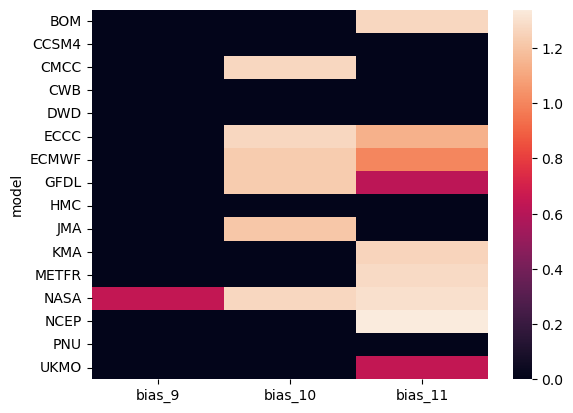

In [34]:
bias_heatmap = (all_bias.loc[(all_bias["init_month"] == 9)].groupby("model")["bias"].mean().reset_index()
                .merge(all_bias.loc[(all_bias["init_month"] == 10)].groupby("model")["bias"].mean().reset_index()
                        .merge(all_bias.loc[(all_bias["init_month"] == 11)].groupby("model")["bias"].mean().reset_index(), on="model", suffixes=("", "_11")), on="model", suffixes=("_9", "_10"))
                .round(2))
sns.heatmap(bias_heatmap.set_index("model"))

<Axes: xlabel='bias', ylabel='feature'>

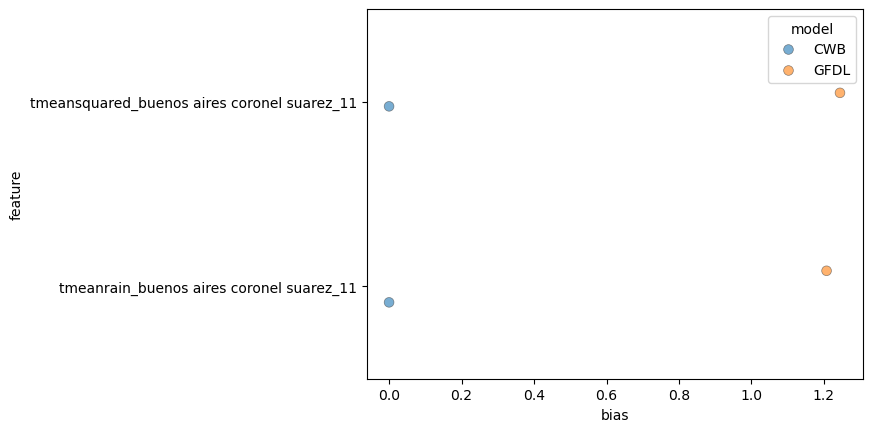

In [35]:
sns.stripplot(data=all_bias.loc[(all_bias["init_month"] == 10) & (all_bias["model"].isin(["CWB", "GFDL"]))], x="bias", y="feature", orient="h", s=7, linewidth=0.5, alpha=.6, hue="model", jitter=True, size=(20,20))

## EXPORT

In [197]:
scm_era.to_csv("files/ERA/features/scm_era_features_filtered_case28.csv", index=False)